# Mental Health in Tech: Predicting Treatment-Seeking Behavior  

## Third Notebook: Objective  

This notebook focuses on building and evaluating predictive models using the cleaned and encoded dataset created in the previous step. After data preparation and exploration, this stage aims to **identify the key factors that influence whether an individual in the tech industry seeks mental health treatment**.  

The modeling process includes:  

- Splitting the dataset into training and testing sets  
- Training various supervised classification models  
- Evaluating model performance using accuracy, precision, recall, F1-score, and ROC-AUC  
- Interpreting model results and identifying the most influential predictors  

The goal is not only to build a performant predictive model, but also to gain insights into how workplace and demographic factors relate to mental health treatment-seeking behaviors.  

**Author:** J-F Jutras  
**Date:** November 2025  
**Dataset:** [Mental Health in Tech Survey (Kaggle)](https://www.kaggle.com/datasets)


## 3.1-Data Loading

The cleaned and encoded dataset generated in the previous notebook is now loaded for model development. The file was saved in the Kaggle working directory under the name 'mental_health_cleaned.csv`.


In [1]:
import pandas as pd

# Load the cleaned dataset for modeling
# (Note: The original 'df' with comments/timeframe will be used later for qualitative analysis)
df_model = pd.read_csv("/kaggle/input/mental-health-cleaned-csv/mental_health_cleaned.csv")

# Display basic information
print("Cleaned modeling dataset successfully loaded!\n")
print(f"Shape: {df_model.shape[0]} rows × {df_model.shape[1]} columns\n")

# Quick overview
df_model.head()

Cleaned modeling dataset successfully loaded!

Shape: 1233 rows × 98 columns



,work_interfere_encoded,no_emp_100-500,no_emp_26-100,no_emp_500-1000,no_emp_6-25,no_emp_More than 1000,Gender_clean_LGBTQ2+,Gender_clean_Male,Gender_clean_Not Specified,Country_clean_Germany,...,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_Yes,remote_work_Yes,treatment_encoded,Age_26-35,Age_36-45,Age_46-55,Age_56+
0,2,0,0,0,0,0,0,1,0,0,...,1,0,1,1,1,0,0,0,1,0
1,4,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,2,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
4,3,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,1,0,0,1,0


## 3.2-Multicollinearity Assessment

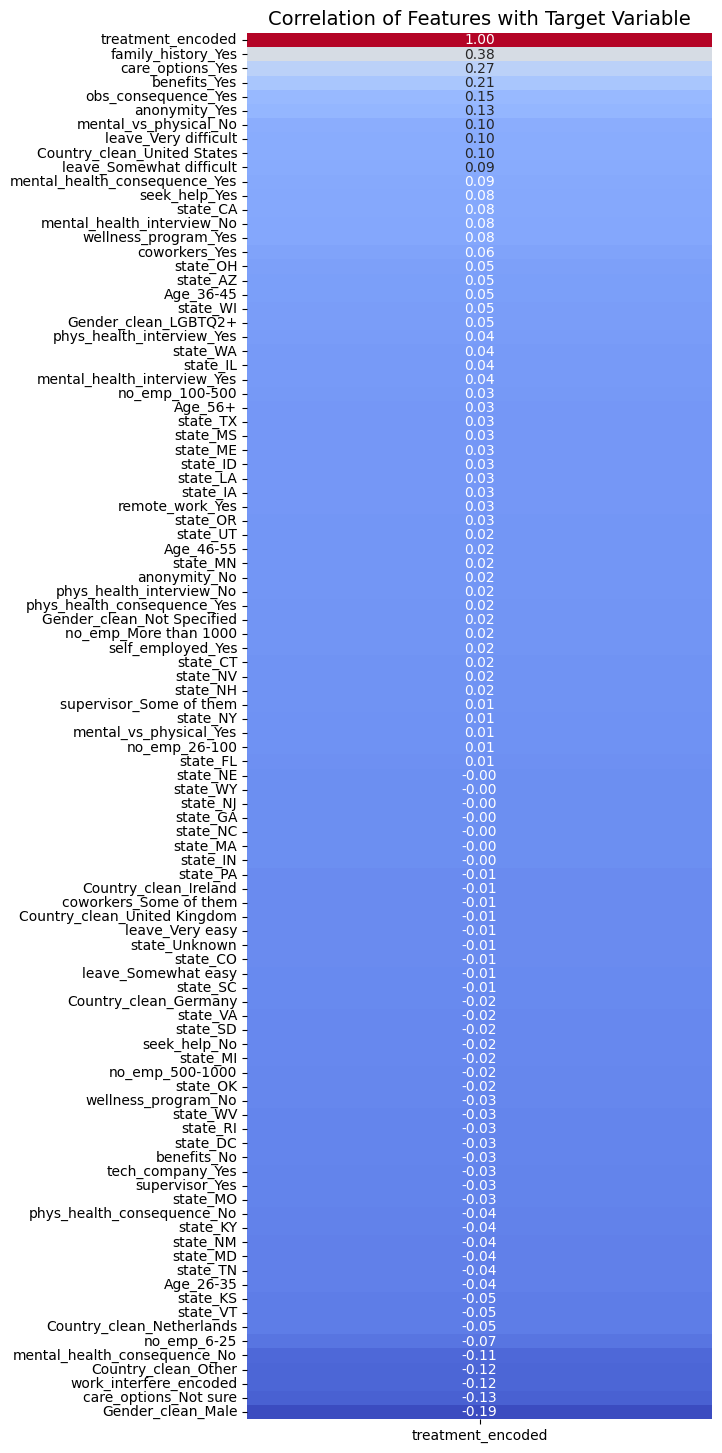

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#Define the target variable
target = 'treatment_encoded'

#Visualize correlations between each feature and the target variable
#This allows to:
#1) Quickly identify features most related to seeking treatment
#2) Get an initial idea of linear relationships
#3) Detect potential multicollinearity between features (high correlation)

#Create heatmap
plt.figure(figsize = (6, 18))
corr_target = df_model.corr()[[target]].sort_values(by = target, ascending = False)
sns.heatmap(corr_target, cmap = 'coolwarm', annot = True, fmt = ".2f", cbar = False)
plt.title("Correlation of Features with Target Variable", fontsize=14)
plt.show()

In [3]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

#Define the feature matrix (exclude the target)
X = df_model.drop(columns = [target])

#Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#Sort features by VIF descending
vif_data = vif_data.sort_values(by ="VIF", ascending = False).reset_index(drop = True)

#Display top 20 features with highest VIF
print("Top features by VIF:\n")
print(vif_data.head(20))

Top features by VIF:

                        Feature        VIF
0   Country_clean_United States  86.875335
1                      state_CA  16.093714
2                      state_WA   8.623142
3    mental_health_interview_No   7.934555
4           wellness_program_No   7.754118
5                      state_NY   6.967831
6              tech_company_Yes   6.754047
7    phys_health_consequence_No   5.904334
8             Gender_clean_Male   5.724649
9                      state_TX   5.662417
10                     state_TN   5.652107
11       coworkers_Some of them   5.470863
12               supervisor_Yes   4.746553
13                 seek_help_No   4.726016
14                    Age_26-35   4.588177
15        no_emp_More than 1000   4.575165
16                     state_OR   4.183911
17                     state_PA   4.125265
18                no_emp_26-100   3.968572
19                 benefits_Yes   3.917643


In [4]:
#Assuming df_model is loaded and contains 'Country_clean_*' and one-hot encoded state columns
#Goal: create a single column 'Provenance' combining country and US state information to reduce
#redundancy and to help lower multicollinearity (VIF) for regression modeling.

#Step 1: define a function to extract provenance
def get_provenance(row):
    if row['Country_clean_United States'] == 1:  #If respondent is from the USA
        #Find which state column is 1
        states = [col for col in df_model.columns if col.startswith('state_')]
        for state in states:
            if row[state] == 1:
                return state.replace('state_', '')  #Keep only the state code
        return 'Unknown'  #Fallback if no state is marked
    else:
        #For non-US respondents, find which country column is 1
        countries = [col for col in df_model.columns if col.startswith('Country_clean_') and col != 'Country_clean_United States']
        for country in countries:
            if row[country] == 1:
                return country.replace('Country_clean_', '')
        return 'Other'  #Fallback

#Step 2: Apply the function to create the new 'Provenance' column
df_model['Provenance'] = df_model.apply(get_provenance, axis=1)

#Step 3: Check the result
print(df_model['Provenance'].value_counts())

Provenance
Other             217
United Kingdom    182
CA                137
WA                 70
NY                 56
Germany            45
TN                 43
TX                 43
PA                 29
OR                 29
Netherlands        27
Ireland            27
OH                 26
IN                 26
IL                 25
MI                 21
MA                 20
MN                 20
Unknown            18
FL                 15
VA                 14
NC                 14
MO                 12
WI                 12
GA                 12
UT                 10
CO                  9
MD                  7
AZ                  7
OK                  6
NJ                  6
KY                  5
SC                  5
DC                  4
IA                  4
CT                  3
SD                  3
VT                  3
NV                  3
NH                  3
KS                  3
NM                  2
NE                  2
WY                  2
WV                  1

In [5]:
#Drop original country and state columns
cols_to_drop = [col for col in df_model.columns if col.startswith('Country_clean_') or col.startswith('state_')]
df_model = df_model.drop(columns=cols_to_drop)

#Verify
print(df_model.shape)
print(df_model.head())

(1233, 48)
   work_interfere_encoded  no_emp_100-500  no_emp_26-100  no_emp_500-1000  \
0                       2               0              0                0   
1                       4               0              0                0   
2                       2               1              0                0   
3                       0               0              0                0   
4                       3               0              1                0   

   no_emp_6-25  no_emp_More than 1000  Gender_clean_LGBTQ2+  \
0            0                      0                     0   
1            1                      0                     0   
2            0                      0                     0   
3            0                      0                     0   
4            0                      0                     0   

   Gender_clean_Male  Gender_clean_Not Specified  self_employed_Yes  ...  \
0                  1                           0                  1  ..

In [6]:
#Encode 'Provenance' for numeric analysis
#One-hot encode 'Provenance' and ensure the resulting columns are numeric
df_model = pd.get_dummies(df_model, columns=['Provenance'], drop_first=True, dtype=int)

#Verify shape and preview
print(f"Dataset shape after encoding Provenance: {df_model.shape}")
df_model.filter(like='Provenance').head()

Dataset shape after encoding Provenance: (1233, 96)


,Provenance_CA,Provenance_CO,Provenance_CT,Provenance_DC,Provenance_FL,Provenance_GA,Provenance_Germany,Provenance_IA,Provenance_ID,Provenance_IL,...,Provenance_TX,Provenance_UT,Provenance_United Kingdom,Provenance_Unknown,Provenance_VA,Provenance_VT,Provenance_WA,Provenance_WI,Provenance_WV,Provenance_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Recalculate Variance Inflation Factor (VIF) after dropping high multicollinearity columns
#VIF helps identify features that are strongly correlated with others, which can destabilize regression coefficients.

# Define the feature matrix (exclude target)
X = df_model.drop(columns=['treatment_encoded'])

# Ensure all columns are numeric
X = X.apply(pd.to_numeric)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by descending VIF and display top 20
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data.head(20)

,Feature,VIF
79,Provenance_Other,9.832437
34,mental_health_interview_No,8.382308
87,Provenance_United Kingdom,8.070635
16,wellness_program_No,8.045238
11,tech_company_Yes,6.907295
46,Provenance_CA,6.803221
28,phys_health_consequence_No,6.022081
7,Gender_clean_Male,5.985726
30,coworkers_Some of them,5.641828
5,no_emp_More than 1000,5.203203


In [8]:
#DROP COLUMNS CAUSING HIGH MULTICOLLINEARITY FOR LOGISTIC REGRESSION

#Many 'Provenance' columns and corresponding Yes/No pairs create high correlation.
#To reduce multicollinearity, we drop these redundant columns, keeping only one representative
#for each binary feature where needed.

# List of columns to drop based on high VIF
cols_to_drop_vif = [
    'Provenance_Other', 'Provenance_United Kingdom', 'Provenance_CA',
    'Provenance_WA', 'wellness_program_No', 'mental_health_interview_No',
    'tech_company_Yes', 'phys_health_consequence_No'
]

#Drop all 'Provenance' columns completely, even if not listed above
cols_provenance = [col for col in df_model.columns if col.startswith('Provenance')]

#Combine all columns to drop
cols_to_drop = list(set(cols_to_drop_vif + cols_provenance))

#Create a new DataFrame for logistic regression
df_model_logreg = df_model.drop(columns=cols_to_drop)

#Verify the result
print(f"Dataset shape after dropping high VIF and Provenance columns: {df_model_logreg.shape}")
df_model_logreg.head()

#Recalculate VIF for df_model_logreg to ensure multicollinearity is reduced
X = df_model_logreg.drop(columns=['treatment_encoded'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Show top 20 VIF features
vif_data.head(20)

Dataset shape after dropping high VIF and Provenance columns: (1233, 43)


,Feature,VIF
27,coworkers_Some of them,5.129721
7,Gender_clean_Male,4.985236
30,supervisor_Yes,4.510940
38,Age_26-35,4.142352
16,seek_help_No,3.732386
12,benefits_Yes,3.629477
5,no_emp_More than 1000,3.572982
0,work_interfere_encoded,3.350981
2,no_emp_26-100,3.110340
11,benefits_No,2.930456


Initially, we examined correlations between each feature and the target variable (treatment_encoded). These correlations were generally weak to moderate (ranging roughly from -0.19 to 0.38), suggesting no alarming linear dependencies with the target.

However, when calculating Variance Inflation Factor (VIF) to assess multicollinearity among predictors, several features—including multiple country/state columns and Yes/No pairs—exhibited high VIF values. High VIFs indicate that these features are strongly correlated with others, which can destabilize logistic regression coefficients and reduce model interpretability.

To mitigate this, we attempted to consolidate country and US state information into a single Provenance column. Although this reduced redundancy, some VIFs remained high. To ensure a stable regression model, we decided to drop all Provenance columns and redundant Yes/No pairs while retaining representative features. All remaining predictors have VIF values below or slightly above 5, which we consider acceptable for logistic regression.

This approach balances information retention with model stability, ensuring interpretable and reliable coefficient estimates.

## 3.3-Logistic Regression Model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Split and train dataset
X = df_model_logreg.drop(columns = ['treatment_encoded'])
y = df_model_logreg['treatment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   
    'penalty': ['l2'], #L2 regularization helps prevent overfitting by shrinking coefficients             
    'solver': ['liblinear'] 
}

#Initialize logistic regression
logreg = LogisticRegression(random_state = 42)

#Perform GridSearch with 5-fold cross-validation to find the best hyperparameters
#while ensuring robust performance across different data splits

grid_search = GridSearchCV(logreg, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
grid_search.fit(X_train, y_train)

#Best parameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Logistic Regression Performance with Regularization: 

Accuracy:  0.688
Precision: 0.676
Recall:    0.736
F1-score:  0.705
ROC-AUC:   0.753 



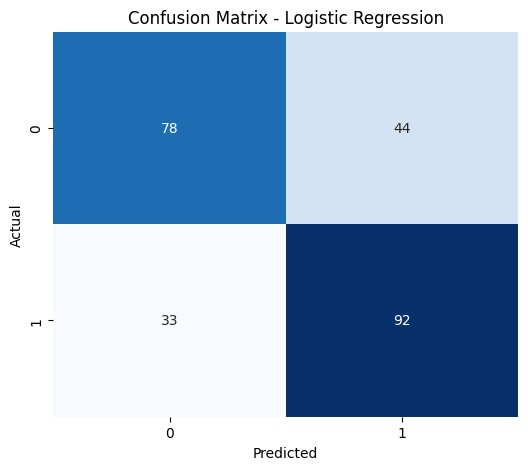

In [10]:
#Fit the model with best params
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test)
y_prob = best_logreg.predict_proba(X_test)[:,1]

#Performance metrics
print("Logistic Regression Performance with Regularization:", "\n")
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:   ", round(recall_score(y_test, y_pred), 3))
print("F1-score: ", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC:  ", round(roc_auc_score(y_test, y_prob), 3), "\n")

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [11]:
# Extract logistic regression coefficients to identify feature effects
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_logreg.coef_[0]
})

#Top 20 features by raw coefficient value
print("Top 20 features influencing treatment-seeking probability:\n")
print(coefficients.sort_values(by = 'Coefficient', ascending = False).head(20))

Top 20 features influencing treatment-seeking probability:

                          Feature  Coefficient
10             family_history_Yes     1.357730
14               care_options_Yes     0.617540
28                  coworkers_Yes     0.493788
12                   benefits_Yes     0.442841
36            obs_consequence_Yes     0.396530
20       leave_Somewhat difficult     0.294158
19                  anonymity_Yes     0.286804
33      phys_health_interview_Yes     0.216549
22           leave_Very difficult     0.203153
27         coworkers_Some of them     0.165529
41                        Age_56+     0.165260
11                    benefits_No     0.149074
25  mental_health_consequence_Yes     0.119400
9               self_employed_Yes     0.101914
40                      Age_46-55     0.075927
23                leave_Very easy     0.057828
31    mental_health_interview_Yes     0.055633
8      Gender_clean_Not Specified     0.030500
34          mental_vs_physical_No     0.024678


## 3.4-Decision Classifier Model

Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

Decision Tree Performance:
Accuracy: 0.794
Precision: 0.750
Recall: 0.888
F1-score: 0.813
ROC-AUC: 0.848


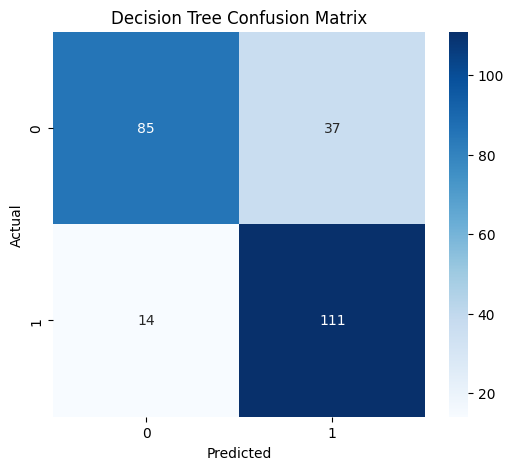

In [12]:
#We'll use GridSearchCV with 5-fold cross-validation to find optimal tree depth and min_samples_split
#This ensures the tree is not too deep (overfitting) or too shallow (underfitting)
#We use our whole cleaned dataset for this model

from sklearn.tree import DecisionTreeClassifier

# Split and train dataset
X = df_model.drop(columns=['treatment_encoded'])
y = df_model['treatment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],           #Limit depth to avoid overfitting
    'min_samples_split': [2, 5, 10],            #Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5],              #Minimum samples at a leaf node
    'criterion': ['gini', 'entropy']            #Measure of split quality
}

#Initialize Decision Tree
dt = DecisionTreeClassifier(random_state = 42)

#GridSearch with 5-fold cross-validation
grid_search_dt = GridSearchCV(dt, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)
grid_search_dt.fit(X_train, y_train)

#Best parameters
best_params_dt = grid_search_dt.best_params_
print("Best hyperparameters for Decision Tree:", best_params_dt)

#Train the best estimator on the full training set
best_dt = grid_search_dt.best_estimator_
y_pred = best_dt.predict(X_test)

#Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_dt.predict_proba(X_test)[:,1])

print(f"\nDecision Tree Performance:\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-score: {f1:.3f}\nROC-AUC: {roc_auc:.3f}")

#Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [13]:
#Feature importances from the trained Decision Tree
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt.feature_importances_
})

#Sort by descending importance
importances_sorted = importances.sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

#Display top 20 features
print("Top 20 features influencing treatment-seeking probability:\n")
print(importances_sorted.head(20))

Top 20 features influencing treatment-seeking probability:

                     Feature  Importance
0     work_interfere_encoded    0.808434
1         family_history_Yes    0.061774
2               benefits_Yes    0.036837
3           care_options_Yes    0.023204
4              anonymity_Yes    0.012500
5            leave_Very easy    0.010083
6           tech_company_Yes    0.008057
7   phys_health_interview_No    0.007716
8                  Age_36-45    0.007565
9             no_emp_100-500    0.005839
10              seek_help_No    0.005631
11       leave_Somewhat easy    0.004565
12           remote_work_Yes    0.003940
13   supervisor_Some of them    0.003857
14             Provenance_IN    0.000000
15             Provenance_MD    0.000000
16             Provenance_NJ    0.000000
17             Provenance_NH    0.000000
18             Provenance_NE    0.000000
19             Provenance_LA    0.000000


## 3.5-Random Forest Classifier

Best hyperparameters for Random Forest: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest Performance on Test Set:
Accuracy:  0.777
Precision: 0.757
Recall:    0.824
F1-score:  0.789
ROC-AUC:   0.867


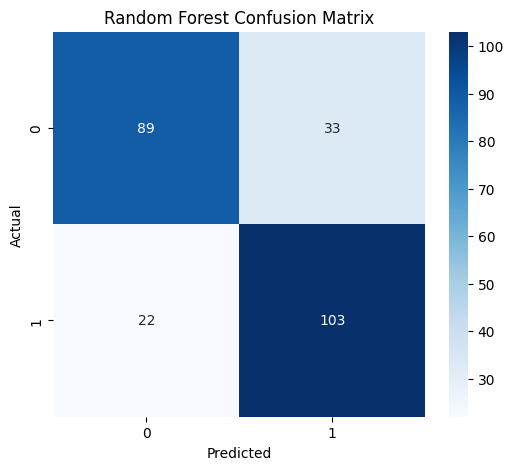

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Split and train dataset
X = df_model.drop(columns = ['treatment_encoded'])
y = df_model['treatment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#Initialize Random Forest
rf = RandomForestClassifier(random_state = 42)

#Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

#GridSearch with 5-fold cross-validation to optimize hyperparameters
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

#Best estimator
best_rf = grid_search_rf.best_estimator_
print("Best hyperparameters for Random Forest:", grid_search_rf.best_params_)

#Predictions on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

#Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nRandom Forest Performance on Test Set:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")

#Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# Feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 features influencing treatment-seeking probability:\n")
print(importances.head(20))


Top 20 features influencing treatment-seeking probability:

                         Feature  Importance
0         work_interfere_encoded    0.272061
10            family_history_Yes    0.097653
15              care_options_Yes    0.036149
13                  benefits_Yes    0.023192
7              Gender_clean_Male    0.022558
21                 anonymity_Yes    0.016833
41               remote_work_Yes    0.015884
79              Provenance_Other    0.015783
40           obs_consequence_Yes    0.015370
32       supervisor_Some of them    0.014703
14         care_options_Not sure    0.014660
26  mental_health_consequence_No    0.013234
28    phys_health_consequence_No    0.013183
36      phys_health_interview_No    0.012980
12                   benefits_No    0.012528
37     phys_health_interview_Yes    0.012159
42                     Age_26-35    0.012137
33                supervisor_Yes    0.012111
23           leave_Somewhat easy    0.012058
30        coworkers_Some of them    0.0

## 3.6-Predictive Modeling Summary

**1. Logistic Regression (L2-regularized)**  
- **Accuracy:** 0.688  
- **F1-score:** 0.705  
- **ROC-AUC:** 0.753  
- **Key positive predictors:** `family_history_Yes`, `care_options_Yes`, `benefits_Yes`  
- Provides interpretable coefficients but shows lower predictive performance.

**2. Decision Tree**  
- **Accuracy:** 0.794  
- **F1-score:** 0.813  
- **ROC-AUC:** 0.848  
- **Top predictor:** `work_interfere_encoded` (~0.81 importance)  
- Captures non-linear interactions, highlighting actionable workplace factors.

**3. Random Forest**  
- **Accuracy:** 0.777  
- **F1-score:** 0.789  
- **ROC-AUC:** 0.867  
- Confirms `work_interfere_encoded` as dominant (~0.27 importance)  
- Stabilizes predictions across interactions; other important factors: `family_history_Yes`, `care_options_Yes`, `benefits_Yes`, `anonymity_Yes`, `remote_work_Yes`.



Model Performance Comparison:



,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.688,0.676,0.736,0.705,0.753
1,Decision Tree,0.794,0.750,0.888,0.813,0.848
2,Random Forest,0.777,0.757,0.824,0.789,0.867


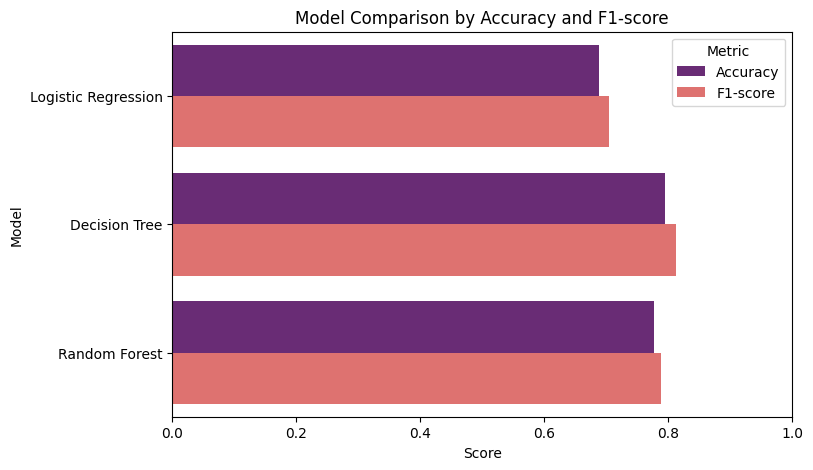

In [16]:
#Create a summary dataframe for all models
model_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [0.688, 0.794, 0.777],
    'Precision': [0.676, 0.750, 0.757],
    'Recall': [0.736, 0.888, 0.824],
    'F1-score': [0.705, 0.813, 0.789],
    'ROC-AUC': [0.753, 0.848, 0.867]
})

#Display table
print("Model Performance Comparison:\n")
display(model_summary)

#Convert the summary dataframe to long format for plotting
model_summary_long = model_summary.melt(id_vars = 'Model', 
                                        value_vars = ['Accuracy', 'F1-score'],
                                        var_name = 'Metric', 
                                        value_name = 'Score')

#Plot Accuracy and F1-score side by side for each model
plt.figure(figsize = (8,5))
sns.barplot(x = 'Score', y = 'Model', hue = 'Metric', data = model_summary_long, palette = 'magma')
plt.xlim(0,1)
plt.title("Model Comparison by Accuracy and F1-score")
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title='Metric')
plt.show()

## 3.7-Save models

In [17]:
import joblib

#Save models
joblib.dump(best_logreg, '/kaggle/working/logistic_model.pkl')
joblib.dump(best_dt, '/kaggle/working/decision_tree_model.pkl')
joblib.dump(best_rf, '/kaggle/working/random_forest_model.pkl')


['/kaggle/working/random_forest_model.pkl']